### Load the WSEAD dataset

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.stats import pearsonr, zscore, mode
from biosppy.signals import ecg
from pyhrv.hrv import hrv
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values, get_time_domain_features, get_frequency_domain_features
from scipy.signal import butter, sosfiltfilt, filtfilt
import neurokit2 as nk
from tqdm import tqdm
#from functions import *

# Define a bunch of constants
SUBJECT_LIST = [2,3,4,5,6,7,8,9,10,11,13,14,15,16,17]
SAMPLING_FREQUENCY = 700 # Hz
SEGMENT_LENGTH = 60 # seconds
WINDOW_STRIDE = 0.25 # seconds (setting segment_length = window_stride means no overlap between windows)

NUM_ACC_FEATURES = 14
NUM_EMG_FEATURES = 15
NUM_RESP_FEATURES = 9
NUM_TEMP_FEATURES = 6
NUM_EDA_FEATURES = 12
NUM_ECG_FEATURES = 14

ACC_FEATURE_NAMES = ['ACC x mean', 'ACC y mean', 'ACC z mean', 'ACC mean', 'ACC x std', 'ACC y std',
                     'ACC z std', 'ACC std', 'ACC abs integral x', 'ACC abs integral y', 'ACC abs integral z',
                     'ACC peak frequency x', 'ACC peak frequency y', 'ACC peak frequency z']
EMG_FEATURE_NAMES = ['EMG mean', 'EMG std', 'EMG median', 'EMG dynamic range', 'EMG absolute integral',
                     'EMG 10th percentile', 'EMG 90th percentile', 'EMG mean frequency', 'EMG median frequency',
                     'EMG peak frequency', 'EMG # peaks', 'EMG mean peak amplitude', 'EMG std peak amplitude', 
                     'EMG sum peak amplitudes', 'EMG normalized sum peak amplitudes']
RESP_FEATURE_NAMES = ['Mean inhale duration', 'Std inhale duration', 'Mean exhale duration', 'Std exhale duration',
                      'Inhale/Exhale ratio', 'Respiration range', 'Respiration rate', 'Respiration duration',
                     'Respiration volume']
TEMP_FEATURE_NAMES = ['Temp mean', 'Temp std', 'Temp min', 'Temp max', 'Temp dynamic range', 'Temp slope']
EDA_FEATURE_NAMES = ['EDA mean', 'EDA std', 'EDA min', 'EDA max', 'EDA mean slope', 'EDA dynamic range',
                     'SCR/SCL mean', 'SCR/SCL std', 'SCL time corr', 'Num SCR segments',
                     'Sum of response durations', 'Area under SCRs']
ECG_FEATURE_NAMES = ['HR mean', 'HR std', 'HRV mean', 'HRV std', 'HRV RMS', 'nn50', 'pnn50', 
                     'ECG VLF energy', 'ECG LF energy', 'ECG HF energy', 'LF/HF ratio', 'ECG total power',
                    'ECG LF component', 'ECG HF component']
FEATURE_NAMES = np.concatenate((ACC_FEATURE_NAMES, EMG_FEATURE_NAMES, RESP_FEATURE_NAMES, TEMP_FEATURE_NAMES,
                                   EDA_FEATURE_NAMES, ECG_FEATURE_NAMES))

In [2]:
## Segmentation functions

def segment_data(data, sampling_rate=700, segment_length=60, window_stride=0.25):
    """
    Segment the given data array into 60-second segments with a sliding window of 0.25 seconds.
    
    Args:
    - data: The data array.
    - sampling_rate: The sampling rate of the data in Hz (default: 700 Hz).
    - segment_length: The length of each segment in seconds (default: 60 seconds).
    - window_stride: The stride of the sliding window in seconds (default: 0.25 seconds).
    
    Returns:
    - segments: A list of segmented data arrays.
    """
    
    segments = []
    start_index = 0
    end_index = int(segment_length * sampling_rate)
    window_stride_samples = int(window_stride * sampling_rate)
    
    while end_index <= len(data):
        segments.append(data[start_index:end_index])
        start_index += window_stride_samples
        end_index += window_stride_samples
    
    return segments


def segment_labels(labels, sampling_rate=700, segment_length=60, window_stride=0.25):
    """
    Segment the labels into 2-second segments with a sliding window of 0.25 seconds.
    
    Args:
    - labels: The labels array.
    - sampling_rate: The sampling rate of the data in Hz (default: 700 Hz).
    - segment_length: The length of each segment in seconds (default: 60 seconds).
    - window_stride: The stride of the sliding window in seconds (default: 0.25 seconds).
    
    Returns:
    - seg_labels: A list containing the majority label for each segment.
    - label_fractions: A list indicating what fraction of the segment the label 
    applies to (maybe useful if a label boundary falls in the middle of the segment)
    """

    seg_labels = []
    label_fractions = []
    start_index = 0
    end_index = int(segment_length * sampling_rate)
    window_stride_samples = int(window_stride * sampling_rate)
    
    while end_index <= len(labels):
        seg_label, label_count = mode(labels[start_index:end_index])
        seg_labels.append(seg_label)
        label_fractions.append(label_count/(end_index-start_index))
        start_index += window_stride_samples
        end_index += window_stride_samples
    
    return seg_labels, label_fractions


def remove_unused_segments(original_dict):
    '''
    Keep only segments that correspond to a valid label (label = 1, 2, or 3)
    where that label is valid for the entire segment (label_fracs = 1).
    '''
    
    labels = np.array(original_dict['labels'])
    label_fracs = np.array(original_dict['label_fracs'])
    mask = (np.isin(labels, [1, 2, 3]) & (label_fracs == 1))
    
    valid_segments_dict = {}
    for data_type in original_dict:
        segments = np.array(original_dict[data_type])
        valid_segments_dict[data_type] = segments[mask]
    
    return valid_segments_dict

### For each subject, get the synchronized data in SX.pkl, one file per subject. 

The double-tap signal pattern was used to manually synchronise the two devices’ raw data. This file is a dictionary, with the following
keys:
- ‘subject’: SX, the subject ID
- ‘signal’: includes all the raw data, in two fields:
    - ‘chest’: RespiBAN data (all the modalities: ACC, ECG, EDA, EMG, RESP, TEMP)
    - ‘wrist’: Empatica E4 data (all the modalities: ACC, BVP, EDA, TEMP)
- ‘label’: ID of the respective study protocol condition, sampled at 700 Hz.

All chest data is sampled at 700Hz

Labels (the ID of the respective study protocol condition)
- 0 = not defined / transient
- 1 = baseline
- 2 = stress
- 3 = amusement
- 4 = meditation
- 5/6/7 = should be ignored in this dataset

In [6]:
SUBJECT_NUM = 2

# The path to the pickle file for this subject
pickle_file_path = f"data/WESAD/S{SUBJECT_NUM}/S{SUBJECT_NUM}.pkl"

try:
    # Open the pickle file in read-binary mode and load the data
    with open(pickle_file_path, "rb") as f:
        loaded_data = pickle.load(f, encoding='latin1')
    
    print(f"Data loaded successfully from the pickle file for Subject {SUBJECT_NUM}:")
    for field in loaded_data:
        print(field)

except FileNotFoundError:
    print("The specified pickle file does not exist.")
except Exception as e:
    print("An error occurred while loading data from the pickle file:", e)
    
# Get chest data and labels
chest_data = loaded_data["signal"]["chest"]
raw_labels = loaded_data["label"]
all_data_dict = {}

# Segment the data
for data_type in chest_data:
    data = chest_data[data_type] 
    segments = segment_data(data, SAMPLING_FREQUENCY, SEGMENT_LENGTH, WINDOW_STRIDE)
    all_data_dict[data_type] = segments

# Segment the labels
labels, label_fractions = segment_labels(raw_labels, SAMPLING_FREQUENCY, SEGMENT_LENGTH, WINDOW_STRIDE)
all_data_dict["labels"] = labels
all_data_dict["label_fracs"] = label_fractions
    
# Remove invalid segments (aka partial segments or segments that correspond to labels we don't care about)
segmented_data_dict = {}
segmented_data_dict = remove_unused_segments(all_data_dict)

NUM_SEGMENTS = len(segmented_data_dict["labels"])
labels = segmented_data_dict["labels"]
LABEL_CHANGE_INDICES = [i for i in range(1, len(labels)) if labels[i] != labels[i-1]] # for graphing

Data loaded successfully from the pickle file for Subject 2:
signal
label
subject


### Plot the labels showing the different study conditions and the raw data for each sensor modality. 

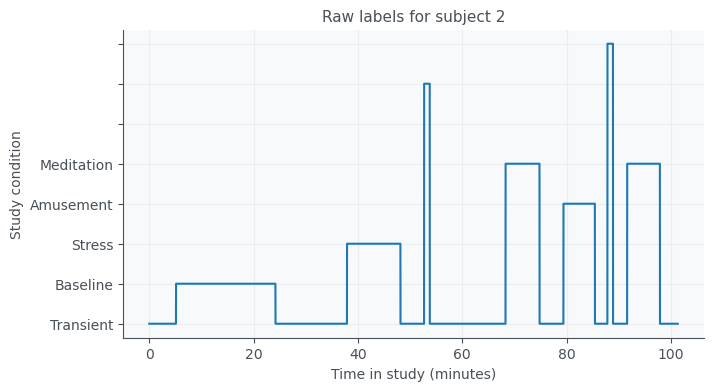

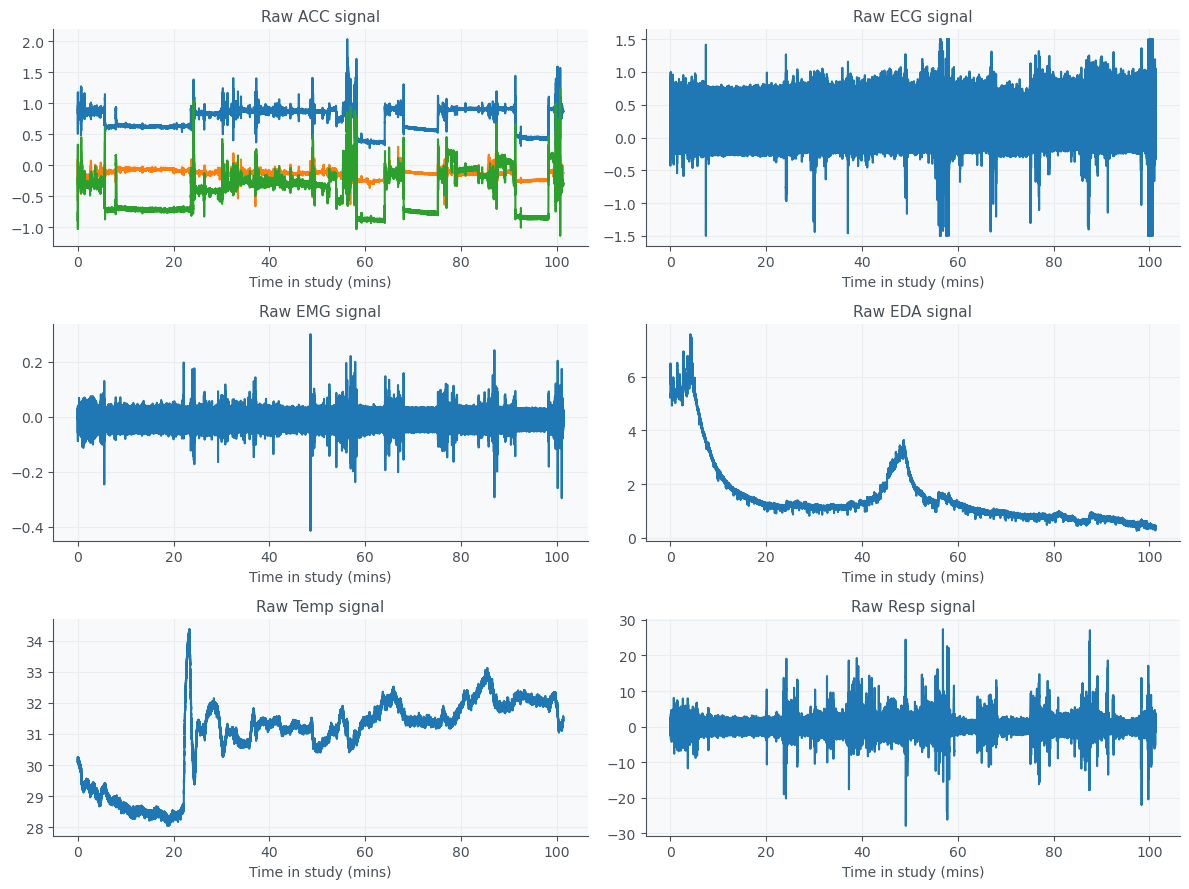

In [4]:
# Plot the study protocol for this subject (different study conditions vs time)
time_axis_mins = np.arange(len(raw_labels)) / SAMPLING_FREQUENCY / 60
plt.figure(figsize=(7.5, 4))  
plt.plot(time_axis_mins, raw_labels)
plt.title(f"Study protocol (labels) for subject {SUBJECT_NUM}")
plt.xlabel("Time in study (minutes)")
plt.ylabel("Study condition")
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], ['Transient','Baseline', 'Stress', 'Amusement', 'Meditation', '', '', ''])
plt.show()

# Plot the raw data for each sensor modality over the course of the study
time_axis_mins = np.arange(len(raw_labels)) / SAMPLING_FREQUENCY / 60
fig, axs = plt.subplots(3, 2, figsize=(12, 9))
for i, key in enumerate(chest_data.keys()):
    row_index = i // 2
    col_index = i % 2
    ax = axs[row_index, col_index]
    ax.plot(time_axis_mins, chest_data[key])
    ax.set_title("Raw " + key + " signal")
    ax.set_xlabel("Time in study (mins)")
plt.tight_layout()
plt.show()

# Optional - Make some plots of labels as a sanity check for label segmentation
plot_label_sanity_check = False
if plot_label_sanity_check:
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].plot(raw_labels)
    axs[0, 0].set_title(f"Raw labels for subject {SUBJECT_NUM}")
    axs[0, 0].set_xlabel("Sample")
    axs[0, 0].set_ylabel("Study condition")

    axs[0, 1].plot(all_data_dict["labels"])
    axs[0, 1].set_title(f"Segment labels for subject {SUBJECT_NUM}")
    axs[0, 1].set_xlabel("Segment")
    axs[0, 1].set_ylabel("Study condition")

    axs[1, 0].plot(all_data_dict["label_fracs"])
    axs[1, 0].set_title("Fraction of segment the label correctly applies to")
    axs[1, 0].set_xlabel("Segment")

    axs[1, 1].plot(segmented_data_dict["labels"])
    axs[1, 1].set_title("Valid labels")
    axs[1, 1].set_xlabel("Segment")
    axs[1, 1].set_ylabel("Study condition")
    axs[1, 1].set_yticks([1, 2, 3])

    plt.tight_layout()
    plt.show()

# Feature Extraction
Using the featues detailed in the "Introducing WESAD" paper.

### Define functions to calculate features for each sensor modality (ACC, EMG, Resp, Temp, EDA, ECG).

TODO: The following features do not vary (std=0). Fix this.

'EMG median frequency', 'ECG VLF energy', 'ECG LF energy', 'LF/HF ratio','ECG LF component', 'ECG HF component'

In [3]:
def get_EDA_features(eda_signal):
    '''
    Extract EDA features using neurokit. 
    The signal is filtered using a 3 Hz low-pass & 4th order Butterworth filter.
    
    Tonic activity is the electrodermal level (aka EDL or SCL), 
    and phasic activity is the electrodermal responses (aka EDR or SCR).
    Calculate the mean, STD, min, max, slope, and dynamic range of the EDA signal.
    Calculate the mean and STD of the SCR/SCL.
    Calculate the correlation btw SCL and time, and the # of identified SCR segments.
    Calculate the sum of the response durations and the area under the identified SCRs.
    '''

    # Process EDA signal, filter using 3 Hz low-pass & 4th order Butterworth
    signals, info = nk.eda_process(eda_signal.flatten(), sampling_rate=SAMPLING_FREQUENCY, method='neurokit')
    
    # Extract EDA features
    mean_eda = np.mean(signals.EDA_Clean)  
    std_eda = np.std(signals.EDA_Clean)  
    min_eda = np.min(signals.EDA_Clean)
    max_eda = np.max(signals.EDA_Clean) 
    mean_slope_eda = np.mean(np.gradient(signals.EDA_Clean))
    dynamic_range = max_eda - min_eda

    # Extract SCR/SCL features
    scr_scl_ratio = signals.EDA_Phasic/signals.EDA_Tonic
    scr_scl_mean = np.mean(scr_scl_ratio)    # Mean of the SCR/SCL
    scr_scl_std = np.std(scr_scl_ratio)      # Standard deviation of the SCR/SCL

    # Calculate correlation between SCL and time
    scl_time_corr, _ = pearsonr(signals.EDA_Tonic, np.arange(0, len(signals.EDA_Tonic)))
    
    # Calculate number of identified SCR segments
    num_scr = np.count_nonzero(signals.SCR_Onsets)

    # Sum of response durations (replace NaN values with 0, indicating no rise/recovery)
    rise_time = np.nan_to_num(info['SCR_RiseTime']) 
    recovery_time = np.nan_to_num(info['SCR_RecoveryTime'])
    sum_durations = np.sum(rise_time) + np.sum(recovery_time)

    # Calculate area under the identified SCRs
    area_under_scrs = np.sum(signals.SCR_Amplitude)
    
    eda_features = [mean_eda, std_eda, min_eda, max_eda, mean_slope_eda, dynamic_range,
               scr_scl_mean, scr_scl_std, scl_time_corr, num_scr, sum_durations, area_under_scrs]

    return eda_features


def get_ACC_features(acc_signal):
    """
    Calculate the mean and STD for each axis separately and summed across all axes. 
    Calculate the absolute integral for each axis.
    Calculate the peak frequency for each axis (assuming 700 Hz sampling rate). 
    
    Returns (in order): 
    X axis mean, Y axis mean, Z axis mean, all axes mean, X axis std, Y axis std, 
    Z axis std, all axes std, X axis absolute integral, Y axis absolute integral, 
    Z axis absolute integral, X axis peak frequency, Y axis peak frequency, Z axis peak frequency.
    """

    acc_x = acc_signal[:,0]
    acc_y = acc_signal[:,1]
    acc_z = acc_signal[:,2]
    
    # Frequency analysis
    frequencies_x, power_spectrum_x = signal.welch(acc_x, fs=SAMPLING_FREQUENCY)
    peak_frequency_x = frequencies_x[np.argmax(power_spectrum_x)]
    frequencies_y, power_spectrum_y = signal.welch(acc_y, fs=SAMPLING_FREQUENCY)
    peak_frequency_y = frequencies_y[np.argmax(power_spectrum_y)]
    frequencies_z, power_spectrum_z = signal.welch(acc_z, fs=SAMPLING_FREQUENCY)
    peak_frequency_z = frequencies_z[np.argmax(power_spectrum_z)]
    
    acc_features = [np.mean(acc_x), np.mean(acc_y), np.mean(acc_z), np.mean(acc_signal),
                    np.std(acc_x), np.std(acc_y), np.std(acc_z), np.std(acc_signal),
                    np.sum(np.abs(acc_x)), np.sum(np.abs(acc_y)), np.sum(np.abs(acc_z)),
                    peak_frequency_x, peak_frequency_y, peak_frequency_z]

    return acc_features


def get_EMG_features(emg_signal):
    '''
    Calculate mean, STD, median, dynamic range, and absolute integral of EMG signal.
    Calculate 10th and 90th percentile.
    Calculate mean, median and peak frequency.
    Calculate # peaks and mean, STD of peak amplitudes.
    Calculate sum and normalized sum of peak amplitudes.
    
    Returns (in order):
    EMG mean, EMG std, EMG median, EMG dynamic range, EMG absolute integral,
    EMG 10th percentile, EMG 90th percentile, mean frequency, median frequency,
    peak frequency, number of peaks, mean peak amplitude, std peak amplitude, 
    sum of peak amplitudes, normalized sum of peak amplitudes.
    '''
    
    # First apply a 4th order 100 Hz highpass Butterworth filter followed by a constant detrending
    filtered_emg = nk.emg_clean(emg_signal, sampling_rate=SAMPLING_FREQUENCY, method='biosppy')
    
    mean_emg = np.mean(filtered_emg)
    std_emg = np.std(filtered_emg)
    median_emg = np.median(filtered_emg)
    dynamic_range = np.max(filtered_emg) - np.min(filtered_emg)
    abs_integral = np.sum(np.abs(filtered_emg))
    percentile_10 = np.percentile(filtered_emg, 10)
    percentile_90 = np.percentile(filtered_emg, 90)
    
    # Frequency analysis
    frequencies, power_spectrum = signal.welch(filtered_emg, fs=SAMPLING_FREQUENCY)
    mean_frequency = np.average(frequencies, weights=power_spectrum)
    median_frequency = np.median(frequencies)
    peak_frequency = frequencies[np.argmax(power_spectrum)]
    
    # Now apply a 50 Hz lowpass filter to the raw signal
    lowcut = 50  
    order = 4
    b, a = signal.butter(order, lowcut / (SAMPLING_FREQUENCY / 2), btype='low')
    filtered_emg_lowpass = signal.filtfilt(b, a, emg_signal.flatten())
    
    # Calculate number of peaks, mean and standard deviation of peak amplitudes
    peaks, _ = signal.find_peaks(filtered_emg_lowpass)
    num_peaks = len(peaks)
    peak_amplitudes = emg_signal[peaks]
    mean_peak_amplitude = np.mean(peak_amplitudes)
    std_peak_amplitude = np.std(peak_amplitudes)
    
    # Calculate sum and normalized sum of peak amplitudes
    sum_peak_amplitudes = np.sum(peak_amplitudes)
    normalized_sum_peak_amplitudes = sum_peak_amplitudes / dynamic_range
    
    emg_features = [mean_emg, std_emg, median_emg, dynamic_range, abs_integral,
                   percentile_10, percentile_90, mean_frequency, median_frequency,
                   peak_frequency, num_peaks, mean_peak_amplitude,
                   std_peak_amplitude, sum_peak_amplitudes, normalized_sum_peak_amplitudes]
    
    return emg_features


def get_resp_features(resp_signal):
    '''
    First processes the signal using a second order 0.05-3 Hz bandpass Butterworth filter, 
    then computes relevant features using neurokit.
    
    Returns (in order):
    Mean inhale duration, std inhale duration, mean exhale duration, std exhale duration, inhale/exhale ratio, 
    respiration range, respiration rate, mean respiration duration, mean respiration volume.
    '''

    # The signal (RSP_Clean) is filtered with a second order 0.05-3 Hz bandpass Butterworth filter
    signals, info = nk.rsp_process(resp_signal, sampling_rate=SAMPLING_FREQUENCY, method='khodadad2018', method_rvt='harrison2021')

    inhale_starts = info['RSP_Troughs'] # indices of respiratory troughs (inhalation onsets)
    inhale_ends = info['RSP_Peaks']
    exhale_starts = info['RSP_Peaks'] # indices of respiratory peaks (exhalation onsets)
    exhale_ends = info['RSP_Troughs']

    # use complete inhales only
    inhale_starts = inhale_starts[:-1] if inhale_starts[-1] > inhale_ends[-1] else inhale_starts
    inhale_ends = inhale_ends[1:] if inhale_ends[0] < inhale_starts[0] else inhale_ends
 
    # use complete exhales only
    exhale_starts = exhale_starts[:-1] if exhale_starts[-1] > exhale_ends[-1] else exhale_starts
    exhale_ends = exhale_ends[1:] if exhale_ends[0] < exhale_starts[0] else exhale_ends

    inhale_durations = (inhale_ends - inhale_starts) / SAMPLING_FREQUENCY
    exhale_durations = (exhale_ends - exhale_starts) / SAMPLING_FREQUENCY

    mean_inhale_duration = np.mean(inhale_durations)
    std_inhale_duration = np.std(inhale_durations)
    mean_exhale_duration = np.mean(exhale_durations)
    std_exhale_duration = np.std(exhale_durations)
    inhale_exhale_ratio = mean_inhale_duration / mean_exhale_duration
    resp_range = np.max(signals.RSP_Clean) - np.min(signals.RSP_Clean)
    resp_rate = np.mean(signals.RSP_Rate)
    resp_duration = np.mean(np.diff(info['RSP_Troughs']) / SAMPLING_FREQUENCY)
    resp_volume = np.mean(signals.RSP_RVT)
    
    resp_features = [mean_inhale_duration, std_inhale_duration, mean_exhale_duration, 
                     std_exhale_duration, inhale_exhale_ratio, resp_range, resp_rate, 
                     resp_duration, resp_volume]
    
    return resp_features


def get_temp_features(temp_signal):
    '''
    Returns (in order): 
    mean, std, min, max, range, and slope of the temp data.
    '''
    
    mean_temp = np.mean(temp_signal)
    std_temp = np.std(temp_signal)
    min_temp = np.min(temp_signal)
    max_temp = np.max(temp_signal)
    dynamic_range = max_temp - min_temp
    mean_slope = np.mean(np.diff(temp_signal.flatten()))
    
    temp_features = [mean_temp, std_temp, min_temp, max_temp,
                    dynamic_range, mean_slope]
    
    return temp_features


def get_ECG_features(ecg_signal):
    '''
    Calculate mean and std of the heart rate. 
    Calculate mean, std, and RMS of the HRV. 
    Calculate the # and percentage of HRV intervals differing more than 50 ms.
    Calculate the energy of all frequency bands (very low, low, and high frequency).
    Calculate the LF/HF ratio, total power over all frequency bands, 
    and the normalized LF and HF component.
    '''
    
    # Process ECG signal ()
    ecg_result = ecg.ecg(signal=ecg_signal.flatten(), sampling_rate=700, show=False);
    r_peaks = ecg_result['rpeaks'];
    rr_intervals_list = np.diff(r_peaks)

    # This remove outliers from signal
   # rr_intervals_without_outliers = remove_outliers(rr_intervals=rr_intervals_list, low_rri=300, high_rri=2000);
    
    # This replace outliers nan values with linear interpolation
  #  interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers, interpolation_method="linear");
    # This removes ectopic beats from signal
   # nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik");
    
    # This replace ectopic beats nan values with linear interpolation
  #  interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list);

    interpolated_nn_intervals = rr_intervals_list
    time_feats = get_time_domain_features(interpolated_nn_intervals)
    freq_feats = get_frequency_domain_features(nn_intervals=interpolated_nn_intervals, sampling_frequency=700)
    
    ecg_features = [time_feats['mean_hr'], time_feats['std_hr'], time_feats['mean_nni'], 
                time_feats['sdsd'], time_feats['rmssd'], time_feats['nni_50'], time_feats['pnni_50'],
                freq_feats['vlf'], freq_feats['lf'], freq_feats['hf'], freq_feats['lf_hf_ratio'],
                freq_feats['total_power'], freq_feats['lfnu'], freq_feats['hfnu']]
                        
    return ecg_features

### Calculate and plot EDA features for this subject.

Calculate and plot EDA features for this subject individually, useful for testing / visualization purposes. 

EDA features = 'EDA mean', 'EDA std', 'EDA min', 'EDA max', 'EDA mean slope', 'EDA dynamic range', 'SCR/SCL mean', 'SCR/SCL std', 'SCL time corr', 'Num SCR segments', 'Sum of response durations', 'Area under SCRs'.

In [ ]:
# Calculate EDA features for each segment
eda_features = np.zeros((NUM_SEGMENTS, NUM_EDA_FEATURES))
for i in tqdm(range(NUM_SEGMENTS)):
    eda_features[i, :] = get_EDA_features(segmented_data_dict["EDA"][i].flatten())

# Plot labels
plt.figure(figsize=(7.5, 4))                      
plt.plot(segmented_data_dict["labels"])
plt.title(f"Segment labels for Subject {SUBJECT_NUM}")
plt.xlabel("Segment")
plt.yticks([1, 2, 3], ['Baseline', 'Stress', 'Amusement'])
plt.tight_layout()
plt.show()

# Plot features (z scored)
plt.figure(figsize=(9, 5))                      
plt.plot(zscore(eda_features))
for index in LABEL_CHANGE_INDICES: # indicate where the test condition changes with a dotted line
    plt.axvline(x=index, color='lightgray', linestyle='--')
plt.title(f"EDA features for Subject {SUBJECT_NUM} (z scored)")
plt.legend(labels=EDA_FEATURE_NAMES, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Segment")
plt.tight_layout()
plt.show()
#plt.savefig('eda_features.png')

### Calculate and plot ACC features for this subject.

Calculate and plot acceleration features for this subject individually, useful for testing / visualization purposes. 

ACC features = 'ACC x mean', 'ACC y mean', 'ACC z mean', 'ACC mean', 'ACC x std', 'ACC y std', 'ACC z std', 'ACC std', 'ACC abs integral x', 'ACC abs integral y', 'ACC abs integral z', 'ACC peak frequency x', 'ACC peak frequency y', 'ACC peak frequency z'.

In [ ]:
# Calculate ACC features for each segment
acc_features = np.zeros((NUM_SEGMENTS, NUM_ACC_FEATURES))
for i in tqdm(range(NUM_SEGMENTS)):
    acc_features[i, :] = get_ACC_features(segmented_data_dict["ACC"][i])

# Plot labels
plt.figure(figsize=(7.5, 4))                      
plt.plot(segmented_data_dict["labels"])
plt.title(f"Segment labels for Subject {SUBJECT_NUM}")
plt.xlabel("Segment")
plt.yticks([1, 2, 3], ['Baseline', 'Stress', 'Amusement'])
plt.tight_layout()
plt.show()

# Plot features (z scored)
plt.figure(figsize=(9, 5))                      
plt.plot(zscore(acc_features))
for index in LABEL_CHANGE_INDICES: # indicate where the test condition changes with a dotted line
    plt.axvline(x=index, color='lightgray', linestyle='--')
plt.title(f"ACC features for Subject {SUBJECT_NUM} (z scored)")
plt.legend(labels=ACC_FEATURE_NAMES, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Segment")
plt.tight_layout()
plt.show()
#plt.savefig('acc_features.png') 

### Calculate and plot EMG features for this subject.

Calculate and plot electromyogram (EMG) features for this subject individually, useful for testing / visualization purposes. 

EMG features = 'EMG mean', 'EMG std', 'EMG median', 'EMG dynamic range', 'EMG absolute integral', 'EMG 10th percentile', 'EMG 90th percentile', 'EMG mean frequency', 'EMG median frequency', 'EMG peak frequency', 'EMG # peaks', 'EMG mean peak amplitude', 'EMG std peak amplitude', 'EMG sum peak amplitudes', 'EMG normalized sum peak amplitudes'.

In [ ]:
# Calculate EMG features for each segment
emg_features = np.zeros((NUM_SEGMENTS, NUM_EMG_FEATURES))
for i in tqdm(range(NUM_SEGMENTS)):
    emg_features[i, :] = get_EMG_features(segmented_data_dict["EMG"][i])

# Plot labels
plt.figure(figsize=(7.5, 4))                      
plt.plot(segmented_data_dict["labels"])
plt.title(f"Segment labels for Subject {SUBJECT_NUM}")
plt.xlabel("Segment")
plt.yticks([1, 2, 3], ['Baseline', 'Stress', 'Amusement'])
plt.tight_layout()
plt.show()

# Plot features (z scored)
plt.figure(figsize=(10, 5))
plt.plot(zscore(emg_features))
for index in LABEL_CHANGE_INDICES: # indicate where the test condition changes with a dotted line
    plt.axvline(x=index, color='lightgray', linestyle='--')
plt.title(f"EMG features for Subject {SUBJECT_NUM} (z scored)")
plt.legend(labels=EMG_FEATURE_NAMES, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Segment")
plt.tight_layout()
plt.show()
#plt.savefig('emg_features.png') 

### Calculate and plot respiration features for this subject.

Calculate and plot respiration features for this subject individually, useful for testing / visualization purposes. 

Resp features = 'Mean inhale duration', 'Std inhale duration', 'Mean exhale duration', 'Std exhale duration', 'Inhale/Exhale ratio', 'Respiration range', 'Respiration rate', 'Respiration duration', 'Respiration volume'.

In [ ]:
# Calculate Resp features for each segment
resp_features = np.zeros((NUM_SEGMENTS, NUM_RESP_FEATURES))
for i in tqdm(range(NUM_SEGMENTS)):
    resp_features[i, :] = get_resp_features(segmented_data_dict["Resp"][i].flatten())

# Plot labels
plt.figure(figsize=(7.5, 4))                      
plt.plot(segmented_data_dict["labels"])
plt.title(f"Segment labels for Subject {SUBJECT_NUM}")
plt.xlabel("Segment")
plt.yticks([1, 2, 3], ['Baseline', 'Stress', 'Amusement'])
plt.tight_layout()
plt.show()

# Plot features (z scored)
plt.figure(figsize=(9, 5))                      
plt.plot(zscore(resp_features))
for index in LABEL_CHANGE_INDICES: # indicate where the test condition changes with a dotted line
    plt.axvline(x=index, color='lightgray', linestyle='--')
plt.title(f"Resp features for Subject {SUBJECT_NUM} (z scored)")
plt.legend(labels=RESP_FEATURE_NAMES, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Segment")
plt.tight_layout()
plt.show()
#plt.savefig('resp_features.png') 

### Calculate and plot temperature features for this subject.

Calculate and plot temperature features for this subject individually, useful for testing / visualization purposes. 

Temp features = 'Temp mean', 'Temp std', 'Temp min', 'Temp max', 'Temp dynamic range', 'Temp slope'.

In [ ]:
# Calculate Temp features for each segment
temp_features = np.zeros((NUM_SEGMENTS, NUM_TEMP_FEATURES))
for i in tqdm(range(NUM_SEGMENTS)):
    temp_features[i, :] = get_temp_features(segmented_data_dict["Temp"][i])

# Plot labels
plt.figure(figsize=(7.5, 4))                      
plt.plot(segmented_data_dict["labels"])
plt.title(f"Segment labels for Subject {SUBJECT_NUM}")
plt.xlabel("Segment")
plt.yticks([1, 2, 3], ['Baseline', 'Stress', 'Amusement'])
plt.tight_layout()
plt.show()

# Plot features (z scored)
plt.figure(figsize=(9, 5))                      
plt.plot(zscore(temp_features))
for index in LABEL_CHANGE_INDICES: # indicate where the test condition changes with a dotted line
    plt.axvline(x=index, color='lightgray', linestyle='--')
plt.title(f"Temp features for Subject {SUBJECT_NUM} (z scored)")
plt.legend(labels=TEMP_FEATURE_NAMES, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Segment")
plt.tight_layout()
plt.show()
#plt.savefig('temp_features.png') 

### Calculate and plot ECG features for this subject.

Calculate and plot electrocardiogram (ECG) features for this subject individually, useful for testing / visualization purposes. 

ECG features = 'HR mean', 'HR std', 'HRV mean', 'HRV std', 'HRV RMS', 'nn50', 'pnn50', 'ECG VLF energy', 'ECG LF energy', 'ECG HF energy', 'LF/HF ratio', 'ECG total power', 'ECG LF component', 'ECG HF component'.

In [ ]:
# Calculate ECG features for each segment
ecg_features = np.zeros((NUM_SEGMENTS, NUM_ECG_FEATURES))
for i in tqdm(range(NUM_SEGMENTS)):
    ecg_features[i, :] = get_ECG_features(segmented_data_dict["ECG"][i].flatten())

# Plot labels
plt.figure(figsize=(7.5, 4))                      
plt.plot(segmented_data_dict["labels"])
plt.title(f"Segment labels for Subject {SUBJECT_NUM}")
plt.xlabel("Segment")
plt.yticks([1, 2, 3], ['Baseline', 'Stress', 'Amusement'])
plt.tight_layout()
plt.show()

# Plot features (z scored)
plt.figure(figsize=(9, 5))                      
plt.plot(zscore(ecg_features))
for index in LABEL_CHANGE_INDICES: # indicate where the test condition changes with a dotted line
    plt.axvline(x=index, color='lightgray', linestyle='--')
plt.title(f"ECG features for Subject {SUBJECT_NUM} (z scored)")
plt.legend(labels=ECG_FEATURE_NAMES, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Segment")
plt.tight_layout()
plt.show()
#plt.savefig('ecg_features.png') 

# Get features for all modalities! 

We have 70 features in total. 

### First define some functions for combining everything.

In [4]:
def load_subject_chest_data(subject_num):
    
    # The path to the pickle file for this subject
    pickle_file_path = f"data/WESAD/S{subject_num}/S{subject_num}.pkl"

    try:
        # Open the pickle file in read-binary mode and load the data
        with open(pickle_file_path, "rb") as f:
            subject_data = pickle.load(f, encoding='latin1')
    except FileNotFoundError:
        print("The specified pickle file does not exist.")
    except Exception as e:
        print("An error occurred while loading data from the pickle file:", e)
          
    chest_data = subject_data["signal"]["chest"]
    raw_labels = subject_data["label"]
    
    return chest_data, raw_labels
    
    
def do_all_segmentation(raw_data, raw_labels, sampling_frequency, segment_length, window_stride):
    
    # Segment the data
    all_data_dict = {}
    for data_type in raw_data:
        data = raw_data[data_type] 
        segments = segment_data(data, sampling_frequency, segment_length, window_stride)
        all_data_dict[data_type] = segments

    # Segment the labels
    labels, label_fractions = segment_labels(raw_labels, sampling_frequency, segment_length, window_stride)
    all_data_dict["labels"] = labels
    all_data_dict["label_fracs"] = label_fractions
    
    # Remove invalid segments
    segmented_data_dict = {}
    segmented_data_dict = remove_unused_segments(all_data_dict)
    
    return segmented_data_dict


def extract_chest_data_features(segmented_data_dict):
    
    # Labels for each data point
    num_segments = len(segmented_data_dict["labels"])
    label_array = segmented_data_dict["labels"]
    
    acc_features = np.zeros((num_segments, NUM_ACC_FEATURES))
    ecg_features = np.zeros((num_segments, NUM_ECG_FEATURES))
    eda_features = np.zeros((num_segments, NUM_EDA_FEATURES))
    emg_features = np.zeros((num_segments, NUM_EMG_FEATURES))
    resp_features = np.zeros((num_segments, NUM_RESP_FEATURES))
    temp_features = np.zeros((num_segments, NUM_TEMP_FEATURES))

    # Calculate features for each segment
    for i in tqdm(range(num_segments)):
        acc_features[i, :] = get_ACC_features(segmented_data_dict["ACC"][i])
        ecg_features[i, :] = get_ECG_features(segmented_data_dict["ECG"][i])
        eda_features[i, :] = get_EDA_features(segmented_data_dict["EDA"][i])
        emg_features[i, :] = get_EMG_features(segmented_data_dict["EMG"][i])
        resp_features[i, :] = get_resp_features(segmented_data_dict["Resp"][i])
        temp_features[i, :] = get_temp_features(segmented_data_dict["Temp"][i])

    # Concatenate features
    feature_array = np.concatenate((acc_features, emg_features, resp_features, temp_features, eda_features, ecg_features), axis=1)

    # Make subject name array
    subject_name_array = np.array([f"S{subject_num}"] * len(feature_array))
    
    feature_dict = {'features': feature_array, 'feature_names': FEATURE_NAMES, 'labels': label_array, 'subject': subject_name_array}
    return feature_dict


def save_subject_features(feature_dict, file_path):
    
    try:
        # Ensure the directory exists
        directory = os.path.dirname(file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
            print("Directory created:", directory)

        # Open the file in binary write mode
        with open(file_path, 'wb') as f:
            # Dump the dictionary to the file
            pickle.dump(feature_dict, f)
        print("Dictionary saved as pickle file:", file_path)
    except Exception as e:
        print("Error:", e)
        print("Failed to save dictionary as pickle file.")


### Loop through subjects and calculate/save features for each one.

Load the chest data, segment it, calculate features for each segment, save them in a dict, save the dict as a pickle file.

In [ ]:
# Load data, get features, and save feature dict for each subject
for subject_num in tqdm(SUBJECT_LIST):
    # Load the chest data and labels for this subject
    chest_data, raw_labels = load_subject_chest_data(subject_num)
    
    # Segment the data
    segmented_data_dict = do_all_segmentation(chest_data, raw_labels, SAMPLING_FREQUENCY, SEGMENT_LENGTH, WINDOW_STRIDE)
    
    # Calculate features for each segment and save them in a dict
    print("Extracing features ... ")
    feature_dict = extract_chest_data_features(segmented_data_dict)
    
    # Save the feature dictionary as a pickle file
    save_file_path = f"features/S{subject_num}/features_updated.pkl"
    save_subject_features(feature_dict, save_file_path)  

### Calculate features for each subject individually.

This takes just under 30 mins per subject to run.

For whatever reason, this is faster than doing it in a loop (above)?? 

Maybe because in the loop my computer is more likely to sleep or dedicate resources to other processes??? Truly idk

In [13]:
subject_num = 17

# Load the chest data and labels for this subject
chest_data, raw_labels = load_subject_chest_data(subject_num)

# Segment the data
segmented_data_dict = do_all_segmentation(chest_data, raw_labels, SAMPLING_FREQUENCY, SEGMENT_LENGTH, WINDOW_STRIDE)
    
# Calculate features for each segment and save them in a dict
print("Extracting features ...")
feature_dict = extract_chest_data_features(segmented_data_dict)

# Save the feature dictionary as a pickle file
save_file_path = f"features/S{subject_num}/features_updated.pkl"
save_subject_features(feature_dict, save_file_path)

Extracting features ...


100%|███████████████████████████████████████| 8384/8384 [29:27<00:00,  4.74it/s]

Dictionary saved as pickle file: features/S17/features_updated.pkl


### Calculate features for each subject individually. But *parallelized*!

This takes ~40 mins per subject to run (vs ~30 mins per subject above).

I thought this would be faster but for reasons unbeknownst to me, this is actually slower than not parallelized. :(

In [ ]:
import concurrent.futures

subject_num = 6

# Load the chest data and labels for this subject
chest_data, raw_labels = load_subject_chest_data(subject_num)

# Chop it up into segments
segmented_data_dict = do_all_segmentation(chest_data, raw_labels, SAMPLING_FREQUENCY, SEGMENT_LENGTH, WINDOW_STRIDE)
    
# Get labels + segments from the dict
num_segments = len(segmented_data_dict["labels"])
label_array = segmented_data_dict["labels"]

# Preallocate feature arrays
acc_features = np.zeros((num_segments, NUM_ACC_FEATURES))
ecg_features = np.zeros((num_segments, NUM_ECG_FEATURES))
eda_features = np.zeros((num_segments, NUM_EDA_FEATURES))
emg_features = np.zeros((num_segments, NUM_EMG_FEATURES))
resp_features = np.zeros((num_segments, NUM_RESP_FEATURES))
temp_features = np.zeros((num_segments, NUM_TEMP_FEATURES))

# Set up function to parallelize
def process_segment(i):
    acc_features[i, :] = get_ACC_features(segmented_data_dict["ACC"][i])
    ecg_features[i, :] = get_ECG_features(segmented_data_dict["ECG"][i])
    eda_features[i, :] = get_EDA_features(segmented_data_dict["EDA"][i])
    emg_features[i, :] = get_EMG_features(segmented_data_dict["EMG"][i])
    resp_features[i, :] = get_resp_features(segmented_data_dict["Resp"][i])
    temp_features[i, :] = get_temp_features(segmented_data_dict["Temp"][i])

# Calculate features for each segment
print("Extracting features ...")
with concurrent.futures.ThreadPoolExecutor() as executor:
    list(tqdm(executor.map(process_segment, range(num_segments)), total=num_segments))

# Concatenate all of the features
feature_array = np.concatenate((acc_features, emg_features, resp_features, temp_features, eda_features, ecg_features), axis=1)

# Make subject name array to add to the dict
subject_name_array = np.array([f"S{subject_num}"] * len(feature_array))

# Create the dict with all of the features + info for this subject
feature_dict = {'features': feature_array, 'feature_names': FEATURE_NAMES, 'labels': label_array, 'subject': subject_name_array}
    
# Save the feature dict as a pickle file
save_file_path = f"features/S{subject_num}/features_updated.pkl"
save_subject_features(feature_dict, save_file_path)

### Load data for all subjects, combine it into a big dictionary, and re-save it

Remove the features that don't vary - these are useless for now. We'll fix them later.
Also, change the subject ID strings (e.g. 'S2') to integers because it's easier for indexing.

Do this 3 times: 

1) Keep the features as-is (no scaling), save as feature_dict
2) Z-score the features within each subject, save as feature_dict_zscored_by_sub
3) Z-score the features across all subjets, save as feature_dict_zscored

In [20]:
def load_dict_from_pickle(file_path):
    try:
        # Open the file in binary read mode
        with open(file_path, 'rb') as f:
            # Load the dictionary from the file
            loaded_dict = pickle.load(f)
        #print("Dictionary loaded from pickle file:", file_path)
        return loaded_dict
    except Exception as e:
        print("Error:", e)
        print("Failed to load dictionary from pickle file.")
    return None

# Load data for all subjects and put it in a big dictionary
all_features = None
for sub in SUBJECT_LIST:
    feature_file_path = f"features/S{sub}/features_updated.pkl"
    subject_dict = load_dict_from_pickle(feature_file_path)
    if all_features is None:
        all_features = subject_dict['features']
        feature_names = subject_dict['feature_names'] # only need this once
        labels = subject_dict['labels']
        subject_id = subject_dict['subject']
    else:
        all_features = np.concatenate((all_features, subject_dict['features']))
        labels = np.concatenate((labels, subject_dict['labels']))
        subject_id = np.concatenate((subject_id, subject_dict['subject']))

# Remove the useless features that don't vary at all (std=0). (TODO: Fix these in a future iteration)
features_to_remove = ['EMG median frequency', 'ECG VLF energy', 'ECG LF energy', 
                      'LF/HF ratio','ECG LF component', 'ECG HF component']
remove_feature_indices = np.where(np.isin(feature_names, features_to_remove))
all_features = np.delete(all_features, remove_feature_indices, axis=1)
feature_names = np.delete(feature_names, remove_feature_indices)

# For the subject array, switch strings (e.g. 'S2') to integers (2)
subject_id_nums = [int(sub_id[1:]) for sub_id in subject_id]

# Create a combined dict with all of the features + info for all subjects
combined_feature_dict = {'features': all_features, 'feature_names': feature_names, 'labels': labels, 'subject': subject_id_nums}

# Save the feature dict as a pickle file
save_file_path = f"features/combined/feature_dict.pkl"
save_subject_features(combined_feature_dict, save_file_path)

Dictionary saved as pickle file: features/combined/feature_dict_zscored.pkl
